In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, select

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii-Copy1.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station= Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Inspector

In [9]:
# Viewing tables through inspector:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')

In [10]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent = engine.execute('SELECT date FROM measurement ORDER BY date DESC LIMIT 1').fetchall()
most_recent

[('2017-08-23',)]

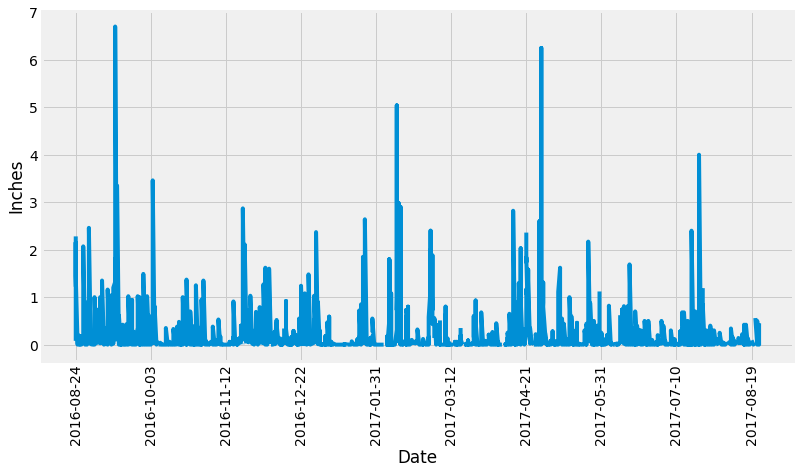

In [44]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

# Perform a query to retrieve the data and precipitation scores
precip_data = engine.execute("SELECT date, prcp FROM measurement WHERE date > '2016-08-23' ORDER BY date ASC").fetchall()
precip_data

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_data_df = pd.DataFrame(precip_data)
precip_data_df = precip_data_df.rename(columns = {0: 'Date', 1: 'Precip'})
precip_data_df = precip_data_df.set_index('Date')

# Sort the dataframe by date
precip_data_df.sort_index(0)

# Use Pandas Plotting with Matplotlib to plot the data
fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor('xkcd:white')

plt.xticks(np.arange(0, len(precip_data), 40), rotation = 90)
plt.ylabel("Inches")
plt.xlabel("Date")
plt.grid(b=True, which='major', axis='both')
plt.savefig("Images/precipitation.png") 
plt.plot(precip_data_df)
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_data_df["Precip"].agg(['mean', 'median', 'var', 'std', 'sem'])

mean      0.176462
median    0.020000
var       0.211865
std       0.460288
sem       0.010254
Name: Precip, dtype: float64

# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
session.query(Measurement.station).distinct(Measurement.station).count()

9

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
station_activity = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).all()
station_activity

# List the stations and the counts in descending order.
# Create function for sorting by count
def date_count(item):
    return item[1]

# sort list with key
station_activity.sort(key=date_count, reverse=True)

# show result
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_temp = conn.execute(select([func.min(Measurement.tobs)]).where(Measurement.station == 'USC00519281'))
max_temp = conn.execute(select([func.max(Measurement.tobs)]).where(Measurement.station == 'USC00519281'))
avg_temp = conn.execute(select([func.avg(Measurement.tobs)]).where(Measurement.station == 'USC00519281'))

print(f'Lowest temperature is: {min_temp.fetchall()}')
print(f'Highest temperature is: {max_temp.fetchall()}')
print(f'Average temperature is: {avg_temp.fetchall()}')

Lowest temperature is: [(54.0,)]
Highest temperature is: [(85.0,)]
Average temperature is: [(71.66378066378067,)]


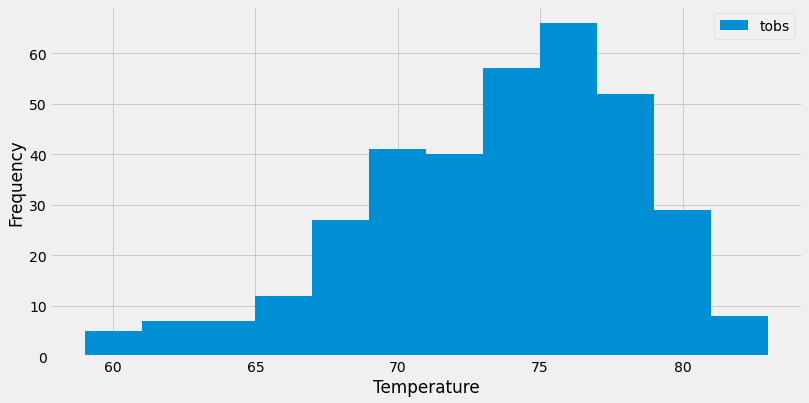

In [91]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Perform a query to retrieve the temperature data
temp_data = engine.execute("SELECT tobs FROM measurement WHERE date > '2016-08-23' AND station == 'USC00519281'").fetchall()
temp_data

# Save the query results as a Pandas DataFrame
temp_data_df = pd.DataFrame(temp_data)
temp_data_df = temp_data_df.rename(columns = {0: 'Temp'})

# Convert df to a list to plot histogram
temp_list = temp_data_df['Temp'].tolist()

# Plot histogram
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(temp_list, bins=12)
ax.legend(['tobs'])
plt.ylabel('Frequency')
plt.xlabel('Temperature')
ax.grid(b=True, which='major', axis='both')

# Save image of plot
plt.savefig("Images/temperature.png") 

# Display output
plt.show()

# Close session

In [92]:
# Close Session
session.close()